# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL per month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
 '2 stars': 50
 '3 stars': 40
 '4 stars': 0
 '5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate other hypothesis instead with part 3.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.


⚠️ Don't start from scratch, update your existing package! 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate profits:
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative IT costs for each row using the function you defined before.
   - Calculate the cumulative net profit for each row.

4️⃣ Plot your results, and analyze them.

5️⃣ Determine the optimum number of sellers to keep, based on profits before and after IT costs. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

6️⃣ How important were the IT costs in your analysis?

In [42]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def calculate_it_costs(n_sellers, n_items):
    alpha = 3157.27
    beta = 978.23
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

In [3]:
from olist.seller_updated import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profit,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,140,3,3,1.000,218.70,341.870,201.870,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,240,40,41,1.025,11703.07,2290.307,2050.307,0.725000,0.050000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0,1,1,1.000,158.00,15.800,15.800,1.000000,0.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0,1,1,1.000,79.99,7.999,7.999,1.000000,0.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,100,1,1,1.000,167.99,16.799,-83.201,0.000000,1.000000,1.00


In [4]:
sorted_sellers = sellers.sort_values(by='profit', ascending=False).reset_index()
sorted_sellers.head()

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profit,share_of_five_stars,share_of_one_stars,review_score
0,868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,5170,358,410,1.145251,222776.05,23237.605,18067.605,0.561798,0.095506,4.132022
1,67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,4700,336,340,1.011905,176431.87,19323.187,14623.187,0.629851,0.101493,4.214925
2,534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,6510,585,586,1.001709,194042.03,21004.203,14494.203,0.676420,0.086059,4.339071
3,2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,1520,166,175,1.054217,79284.55,8808.455,7288.455,0.692771,0.066265,4.421687
4,2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,7500,521,542,1.040307,128111.19,14651.119,7151.119,0.629126,0.112621,4.194175


In [5]:
sorted_sellers['cumulative_profit'] = sorted_sellers['profit'].cumsum()
sorted_sellers['cumulative_sellers'] = sorted_sellers.index + 1
sorted_sellers['cumulative_items'] = sorted_sellers['quantity'].cumsum()
sorted_sellers['cumulative_it_costs'] = sorted_sellers.apply(
    lambda row: calculate_it_costs(row['cumulative_sellers'], row['cumulative_items']),
    axis=1
)
sorted_sellers['cumulative_net_profit'] = sorted_sellers['cumulative_profit'] - sorted_sellers['cumulative_it_costs']
sorted_sellers.head()

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,cost_of_reviews,...,revenues,profit,share_of_five_stars,share_of_one_stars,review_score,cumulative_profit,cumulative_sellers,cumulative_items,cumulative_it_costs,cumulative_net_profit
0,868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,5170,...,23237.605,18067.605,0.561798,0.095506,4.132022,18067.605,1,410,22964.917828,-4897.312828
1,67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,4700,...,19323.187,14623.187,0.629851,0.101493,4.214925,32690.792,2,750,31254.985925,1435.806075
2,534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,6510,...,21004.203,14494.203,0.676420,0.086059,4.339071,47184.995,3,1336,41224.163282,5960.831718
3,2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,1520,...,8808.455,7288.455,0.692771,0.066265,4.421687,54473.450,4,1511,44339.889079,10133.560921
4,2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,7500,...,14651.119,7151.119,0.629126,0.112621,4.194175,61624.569,5,2053,51383.513743,10241.055257


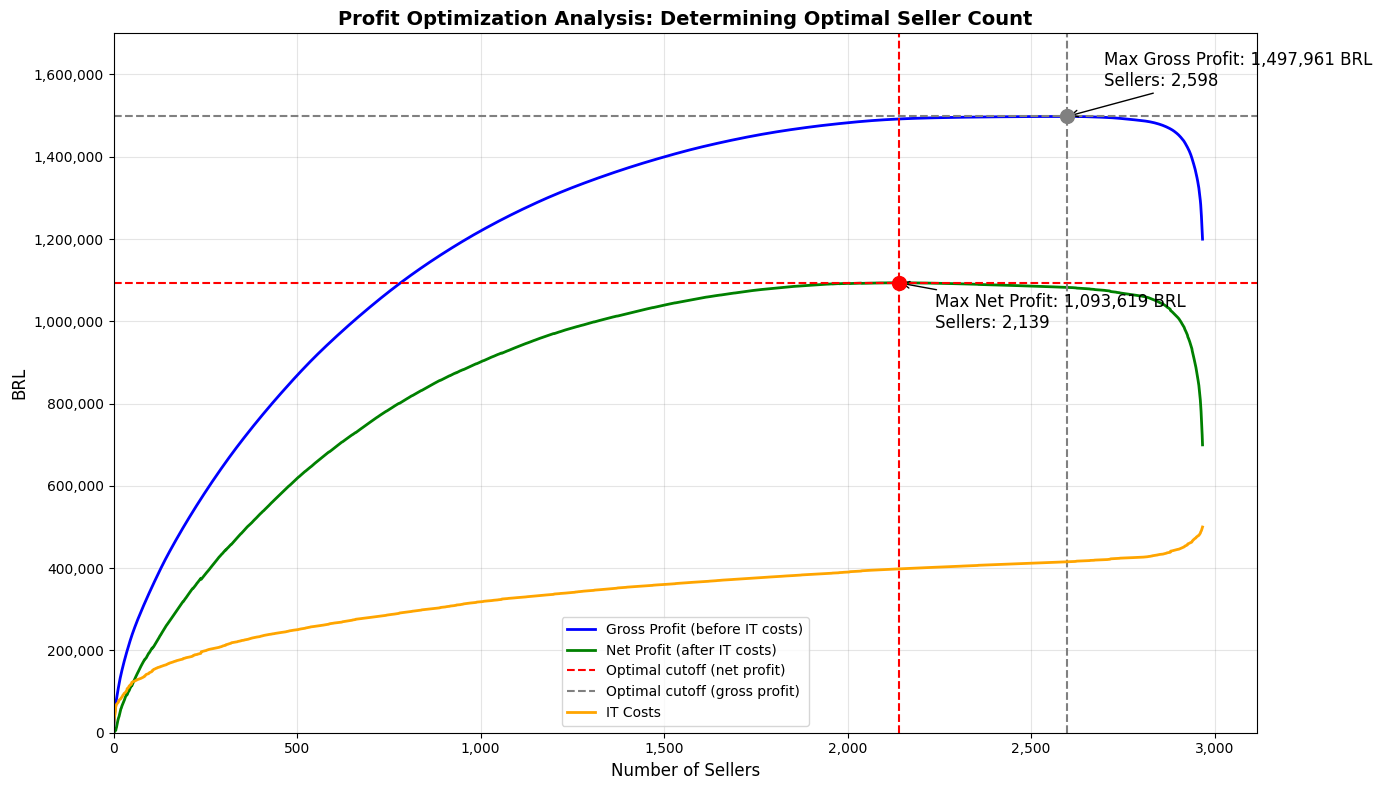

In [60]:
plt.figure(figsize=(14, 8))

# Profit before and after IT costs
plt.plot(sorted_sellers['cumulative_sellers'], sorted_sellers['cumulative_profit'], 
         label='Gross Profit (before IT costs)', color='blue', linewidth=2)
plt.plot(sorted_sellers['cumulative_sellers'], sorted_sellers['cumulative_net_profit'], 
         label='Net Profit (after IT costs)', color='green', linewidth=2)

# Optimal points for net profit
optimal_idx_net = sorted_sellers['cumulative_net_profit'].idxmax()
optimal_sellers_net = sorted_sellers.iloc[optimal_idx_net]['cumulative_sellers']
optimal_profit_net = sorted_sellers.iloc[optimal_idx_net]['cumulative_net_profit']

# Lines at maximum net profit
plt.axhline(optimal_profit_net, color='red', linestyle='--', linewidth=1.5)
plt.axvline(optimal_sellers_net, color='red', linestyle='--', linewidth=1.5, 
           label='Optimal cutoff (net profit)')
plt.scatter(optimal_sellers_net, optimal_profit_net, color='red', s=100, zorder=5)

# Annotate max net profit
plt.annotate(f'Max Net Profit: {optimal_profit_net:,.0f} BRL\nSellers: {int(optimal_sellers_net):,}',
             xy=(optimal_sellers_net, optimal_profit_net),
             xytext=(optimal_sellers_net+100, optimal_profit_net*0.9),
             arrowprops=dict(arrowstyle='->'),
             fontsize=12)

# Show optimal points for gross profit
optimal_idx_gross = sorted_sellers['cumulative_profit'].idxmax()
optimal_sellers_gross = sorted_sellers.iloc[optimal_idx_gross]['cumulative_sellers']
optimal_profit_gross = sorted_sellers.iloc[optimal_idx_gross]['cumulative_profit']

# Lines at maximum gross profit
plt.axhline(optimal_profit_gross, color='grey', linestyle='--', linewidth=1.5)
plt.axvline(optimal_sellers_gross, color='grey', linestyle='--', linewidth=1.5,
           label='Optimal cutoff (gross profit)')
plt.scatter(optimal_sellers_gross, optimal_profit_gross, color='grey', s=100, zorder=5)

# Annotate max gross profit
plt.annotate(f'Max Gross Profit: {optimal_profit_gross:,.0f} BRL\nSellers: {int(optimal_sellers_gross):,}',
             xy=(optimal_sellers_gross, optimal_profit_gross),
             xytext=(optimal_sellers_gross+100, optimal_profit_gross*1.05),
             arrowprops=dict(arrowstyle='->'),
             fontsize=12)

# show IT costs
it_costs_at_cutoff = sorted_sellers.iloc[optimal_idx]['cumulative_profit'] - sorted_sellers.iloc[optimal_idx]['cumulative_net_profit']
plt.plot(sorted_sellers['cumulative_sellers'], sorted_sellers['cumulative_profit'] - sorted_sellers['cumulative_net_profit'], label='IT Costs', color='orange', linestyle='-', linewidth=2)

# labels and styling
plt.xlabel('Number of Sellers', fontsize=12)
plt.ylabel('BRL', fontsize=12)
plt.title('Profit Optimization Analysis: Determining Optimal Seller Count', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='-', alpha=0.2, color='gray')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 1700000)
plt.yticks(np.arange(0, 1600001, 200000))
plt.xlim(0, sorted_sellers['cumulative_sellers'].max() * 1.05)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
print("max_profit_index:", max_profit_index)
print("max_profit:", max_profit)
print("optimal_sellers1:", optimal_sellers1)
print("\n")
print("max_net_profit_index:", max_net_profit_index)
print("max_net_profit:", max_net_profit)
print("optimal_sellers2:", optimal_sellers2)

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

## Exploration

### Optimizing Product Categories

In [ ]:
from olist.product_updated import Product
products = Product().get_training_data()
products.head()

In [ ]:
categories = Product().get_product_cat()
categories.head()

In [ ]:
sellers_per_cat = Product().get_sellers_per_cat()
sellers_per_cat.head()

In [ ]:
selected_columns = [
    "category", 
    "wait_time", 
    "price", 
    "cost_of_reviews", 
    "review_score", 
    "n_orders", 
    "quantity", # aggregated from order_items
    "sales", 
    "n_sellers",
    "avg_months_on_olist"
]
categories_with_sellers = categories.merge(sellers_per_cat, on="category")[selected_columns]
categories_with_sellers.head()

In [ ]:
olist_sales_cut = 0.1
olist_monthly_fee = 80

categories_with_sellers["revenues"] = (
    (categories_with_sellers["sales"] * olist_sales_cut) + 
    (categories_with_sellers["n_sellers"] * olist_monthly_fee * categories_with_sellers["avg_months_on_olist"])
)
categories_with_sellers["profit"] = categories_with_sellers["revenues"] - categories_with_sellers["cost_of_reviews"]

sorted_categories = categories_with_sellers.sort_values(by='profit', ascending=False).reset_index(drop=True)
sorted_categories

In [ ]:
sorted_categories["cumulative_items"] = sorted_categories["quantity"].cumsum()
sorted_categories["cumulative_sellers"] = sorted_categories["n_sellers"].cumsum()
sorted_categories["cumulative_profit"] = sorted_categories["profit"].cumsum()
sorted_categories["cumulative_it_costs"] = sorted_categories.apply(
    lambda row: calculate_it_costs(row["cumulative_sellers"], row["cumulative_items"]),
    axis=1
)
sorted_categories["cumulative_net_profit"] = sorted_categories["cumulative_profit"] - sorted_categories["cumulative_it_costs"]
sorted_categories

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sorted_categories['cumulative_profit'], label='profit')
plt.plot(sorted_categories['cumulative_net_profit'], label='net profit')
plt.xlabel('Number of Categories')
plt.ylabel('Cumulative Profit (BRL)')
plt.legend()

In [ ]:
max_profit_index = np.argmax(sorted_categories['cumulative_profit'])
max_profit = sorted_categories.iloc[max_profit_index]['cumulative_profit']
optimal_categories1 = max_profit_index + 1  # Number of categories (index + 1)

max_net_profit_index = np.argmax(sorted_categories['cumulative_net_profit'])
max_net_profit = sorted_categories.iloc[max_net_profit_index]['cumulative_net_profit']
optimal_categories2 = max_net_profit_index + 1  # Number of categories (index + 1)

print("max_profit_index:", max_profit_index)
print("max_profit:", max_profit)
print("optimal_categories1:", optimal_categories1)
print("\n")
print("max_net_profit_index:", max_net_profit_index)
print("max_net_profit:", max_net_profit)
print("optimal_categories2:", optimal_categories2)

In [ ]:
categories_to_keep = sorted_categories.iloc[:optimal_categories2]['category'].tolist()
categories_to_drop = sorted_categories.iloc[optimal_categories2:]['category'].tolist()

print("Categories to drop:")
for i, category in enumerate(categories_to_drop):
    print(f"{i+1}. {category}")

print(f"Net profit: {max_net_profit} BRL")

### Validation

In [ ]:
# Note: there is going to be a delta since there are some products that have no categories

total_sales_from_categories = categories_with_sellers['sales'].sum()
total_sales_from_sellers = sellers['sales'].sum()

print(f"Total sales from categories: {total_sales_from_categories:.2f}")
print(f"Total sales from sellers: {total_sales_from_sellers:.2f}")
print(f"Difference: {total_sales_from_categories - total_sales_from_sellers:.2f}")
print(f"Percentage difference: {((total_sales_from_categories - total_sales_from_sellers) / total_sales_from_sellers) * 100:.4f}%")

total_items_from_categories = categories_with_sellers['quantity'].sum()
total_items_from_sellers = sellers['quantity'].sum()

print(f"\nTotal items from categories: {total_items_from_categories}")
print(f"Total items from sellers: {total_items_from_sellers}")
print(f"Difference: {total_items_from_categories - total_items_from_sellers}")
print(f"Percentage difference: {((total_items_from_categories - total_items_from_sellers) / total_items_from_sellers) * 100:.4f}%")

In [ ]:
# Validation between categories and sellers
# Assuming we have sorted_categories and sorted_sellers dataframes already

# Get totals from category analysis
total_revenues_categories = sorted_categories['revenues'].sum()
total_cost_of_reviews_categories = sorted_categories['cost_of_reviews'].sum()
total_sellers_categories = sorted_categories['n_sellers'].sum()
total_quantity_categories = sorted_categories['quantity'].sum()
total_profit_categories = sorted_categories['profit'].sum()

# Get totals from seller analysis
total_revenues_sellers = sorted_sellers['revenues'].sum()
total_cost_of_reviews_sellers = sorted_sellers['cost_of_reviews'].sum() 
total_sellers_sellers = len(sorted_sellers)
total_quantity_sellers = sorted_sellers['quantity'].sum()
total_profit_sellers = sorted_sellers['profit'].sum()

# Compare the totals
print("VALIDATION: CATEGORIES vs SELLERS")
print(f"Total revenues: {total_revenues_categories:.2f} vs {total_revenues_sellers:.2f}, Diff: {(total_revenues_categories - total_revenues_sellers):.2f}, {(total_revenues_categories - total_revenues_sellers) / total_revenues_sellers:.2%}")
print(f"Total cost of reviews: {total_cost_of_reviews_categories:.2f} vs {total_cost_of_reviews_sellers:.2f}, Diff: {(total_cost_of_reviews_categories - total_cost_of_reviews_sellers):.2f}, {(total_cost_of_reviews_categories - total_cost_of_reviews_sellers) / total_cost_of_reviews_sellers:.2%}")
print(f"Total sellers: {total_sellers_categories} vs {total_sellers_sellers}, Diff: {total_sellers_categories - total_sellers_sellers}")
print(f"Total quantity: {total_quantity_categories} vs {total_quantity_sellers}, Diff: {total_quantity_categories - total_quantity_sellers}, {(total_quantity_categories - total_quantity_sellers) / total_quantity_sellers:.2%}")
print(f"Total profit: {total_profit_categories:.2f} vs {total_profit_sellers:.2f}, Diff: {(total_profit_categories - total_profit_sellers):.2f}, {(total_profit_categories - total_profit_sellers) / total_profit_sellers:.2%}")
